# Import all the libraries required and cofiguring the GPU

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix,roc_curve,precision_recall_curve,auc,roc_auc_score
import itertools
from itertools import cycle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Load the trained model
model =load_model('D:/University 3rd year/Dissertation/Code/Code for dissertation/ResNet101V2/Checkpoint_ResNet101V2-V6/Model.h5')

# Use Image data generator for data augmentation

In [3]:
validation_data_dir = 'D:/University 3rd year/Dissertation/Code/Training_data_c'#Instantiate the path for validation dataset
#Set the variables for data augmentation
test_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                 )
#Apply data augmentation on validation set
test_set = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(224, 224),
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        batch_size=128)
test_set.class_indices

Found 56777 images belonging to 7 classes.


{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

# Create a list with the label of each picture

In [4]:
actual_emotion_name=[]
actual_emotion_array=[]
emotion_name=[ 'Anger','Disgust','Fear', 'Happy', 'Neutral','Sad', 'Surprise']
emotion_array=[0,0,0,0,0,0,0]

filenames = test_set.filenames

for name in filenames:
    actual_emotion_name.append(str(name).split("\\")[0])
    for i in range(len(emotion_name)):
            if str(name).split("\\")[0] == emotion_name[i]:                
                emotion_array[i]=1
                actual_emotion_array.append(emotion_array)
            else:
                emotion_array=[0,0,0,0,0,0,0]
              
nb_samples = len(filenames)

# Create a result map

In [5]:
test_set.class_indices
TrainClasses=test_set.class_indices
 
# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
 
# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)
 
# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

 The Number of output neurons:  7


# Make prediction on the validtion set and create a list with the name of the emotion predicted

In [6]:
predict = model.predict(test_set,verbose=0)#Make prediction
prediction_name=[]#Create a list
for i in range(len(predict)):
       prediction_name.append(ResultMap[np.argmax(predict[i])])#Add the name of the predicted picture to the list using the result map

# Create and plot a confusion matrix

<AxesSubplot:xlabel='Predicted %', ylabel='Actual %'>

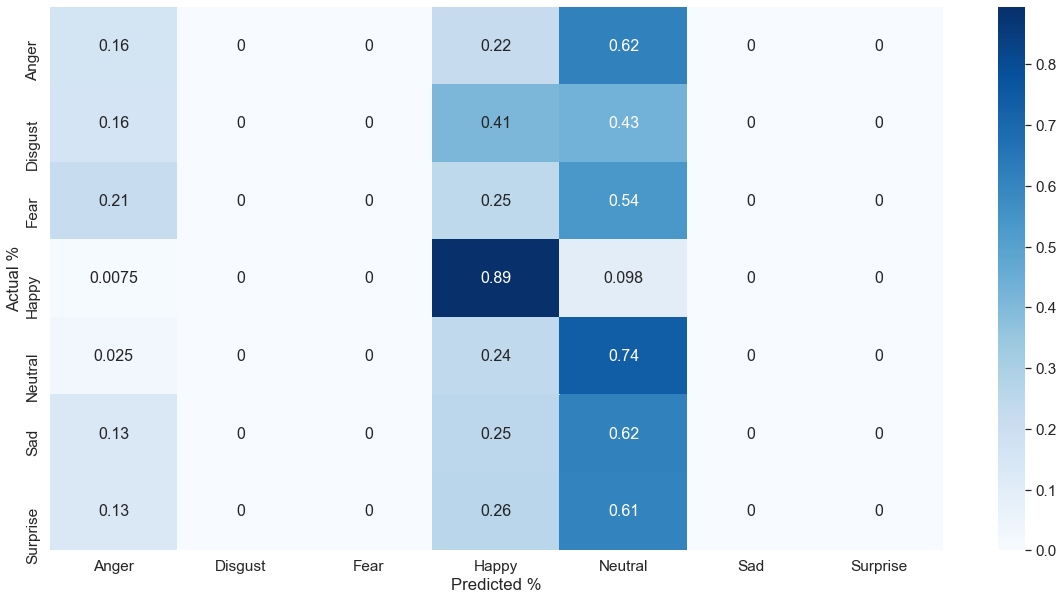

In [9]:
cm=confusion_matrix(actual_emotion_name, prediction_name)#Create the confusion matrix
cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]#Normalise the confusion matrix
#Plot the cofusion matrix
df_cm = pd.DataFrame(cm, columns=np.unique(emotion_name), index = np.unique(emotion_name))
df_cm.index.name = 'Actual %'
df_cm.columns.name = 'Predicted %'
plt.figure(figsize = (20,10))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

# Create and print the classification report

In [10]:
from sklearn.metrics import classification_report
print(classification_report(actual_emotion_name, prediction_name))

C:\Users\Alexandru Neagu\Anaconda3anaconda3\envs\Facial_emotion_recognition_gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Anger       0.29      0.16      0.21      4976
     Disgust       0.00      0.00      0.00       760
        Fear       0.00      0.00      0.00      1275
       Happy       0.77      0.89      0.83     26883
     Neutral       0.49      0.74      0.59     14974
         Sad       0.00      0.00      0.00      5091
    Surprise       0.00      0.00      0.00      2818

    accuracy                           0.63     56777
   macro avg       0.22      0.26      0.23     56777
weighted avg       0.52      0.63      0.56     56777



C:\Users\Alexandru Neagu\Anaconda3anaconda3\envs\Facial_emotion_recognition_gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alexandru Neagu\Anaconda3anaconda3\envs\Facial_emotion_recognition_gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Create and plot the ROC curve for each class

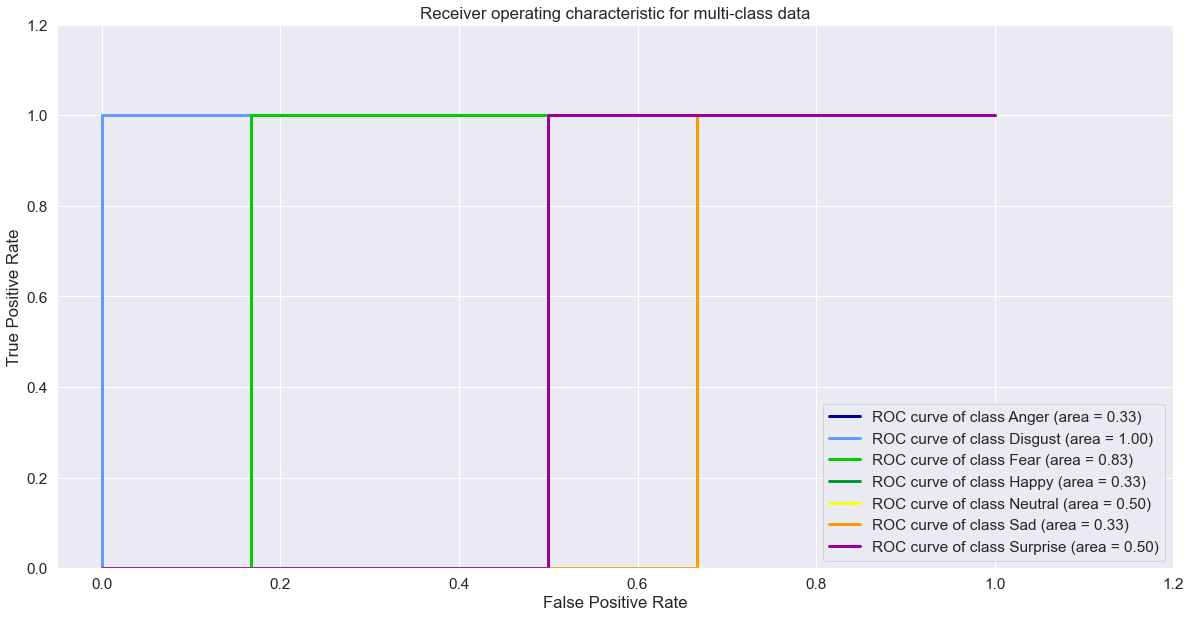

In [11]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(20,10))
for i in range(len(emotion_name)):
    fpr[i], tpr[i], threshold = roc_curve(actual_emotion_array[:][i], predict[:][i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['#000099', '#6699ff', '#00cc00','#009933','#ffff00','#ff9900','#990099'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color,lw=3,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(emotion_name[i], roc_auc[i]))


plt.xlim([-0.05, 1.2])
plt.ylim([0.0, 1.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Create and plot the PR curve for each class

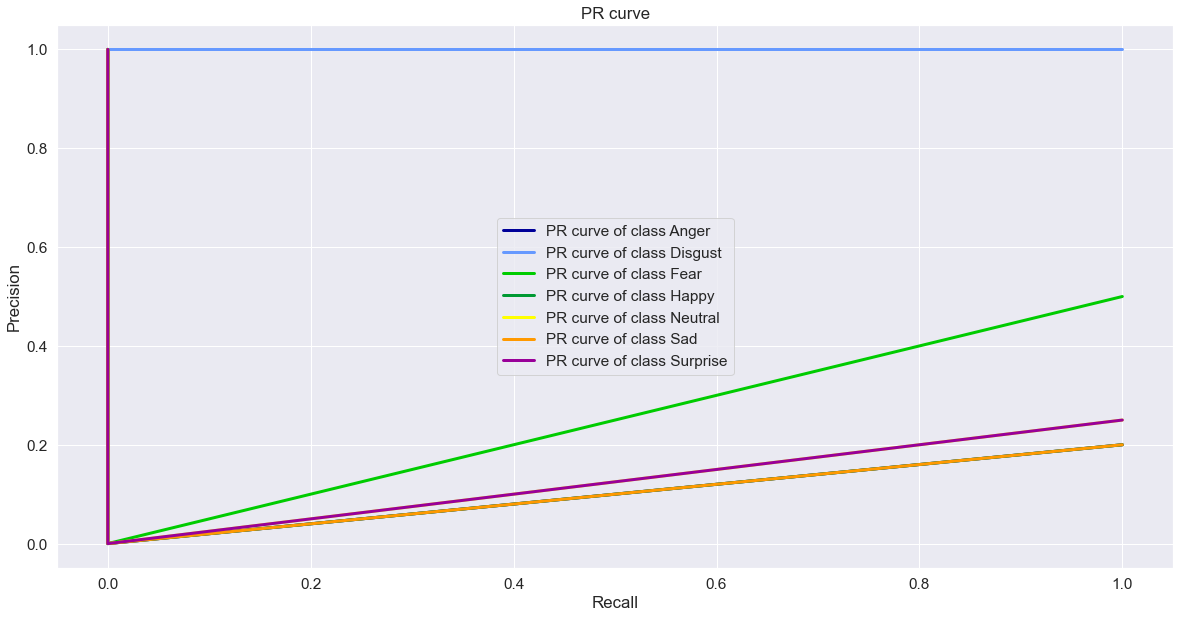

In [12]:
precision = dict()
recall = dict()
plt.figure(figsize=(20,10))
for i in range(len(emotion_name)):
    precision[i], recall[i], _= precision_recall_curve(actual_emotion_array[:][i], predict[:][i])

colors = cycle(['#000099', '#6699ff', '#00cc00','#009933','#ffff00','#ff9900','#990099'])
for i, color in zip(range(7), colors):
    plt.plot(recall[i], precision[i], color=color,lw=3,
             label='PR curve of class {0}'
             ''.format(emotion_name[i]))


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("PR curve")
plt.show()